In [1]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [2]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE))
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            #img = cv2.equalizeHist(img)
            img = cv2.GaussianBlur(img,(5,5),cv2.BORDER_DEFAULT)
            arr=np.array(img)
            #arr1=np.repeat(arr[..., np.newaxis], 3, -1)
            IMG.append(arr)

    return IMG

benign_train = np.array(Dataset_loader("C:\\Users\\Varsha\\Desktop\\DataSources\\BreaKHis 400X\\train\\benign", 224))
malign_train = np.array(Dataset_loader("C:\\Users\\Varsha\\Desktop\\DataSources\\BreaKHis 400X\\train\\malignant", 224))
benign_test = np.array(Dataset_loader("C:\\Users\\Varsha\\Desktop\\DataSources\\BreaKHis 400X\\test\\benign", 224))
malign_test = np.array(Dataset_loader("C:\\Users\\Varsha\\Desktop\\DataSources\\BreaKHis 400X\\test\\malignant", 224))


100%|████████████████████████████████████████████████████████████████████████████████| 369/369 [00:12<00:00, 29.83it/s]


In [3]:
# Breast Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [4]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (Batch  (None, 1920)              7680      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                                 
Total params: 18333506 (69.94 MB)
Trainable params: 1810

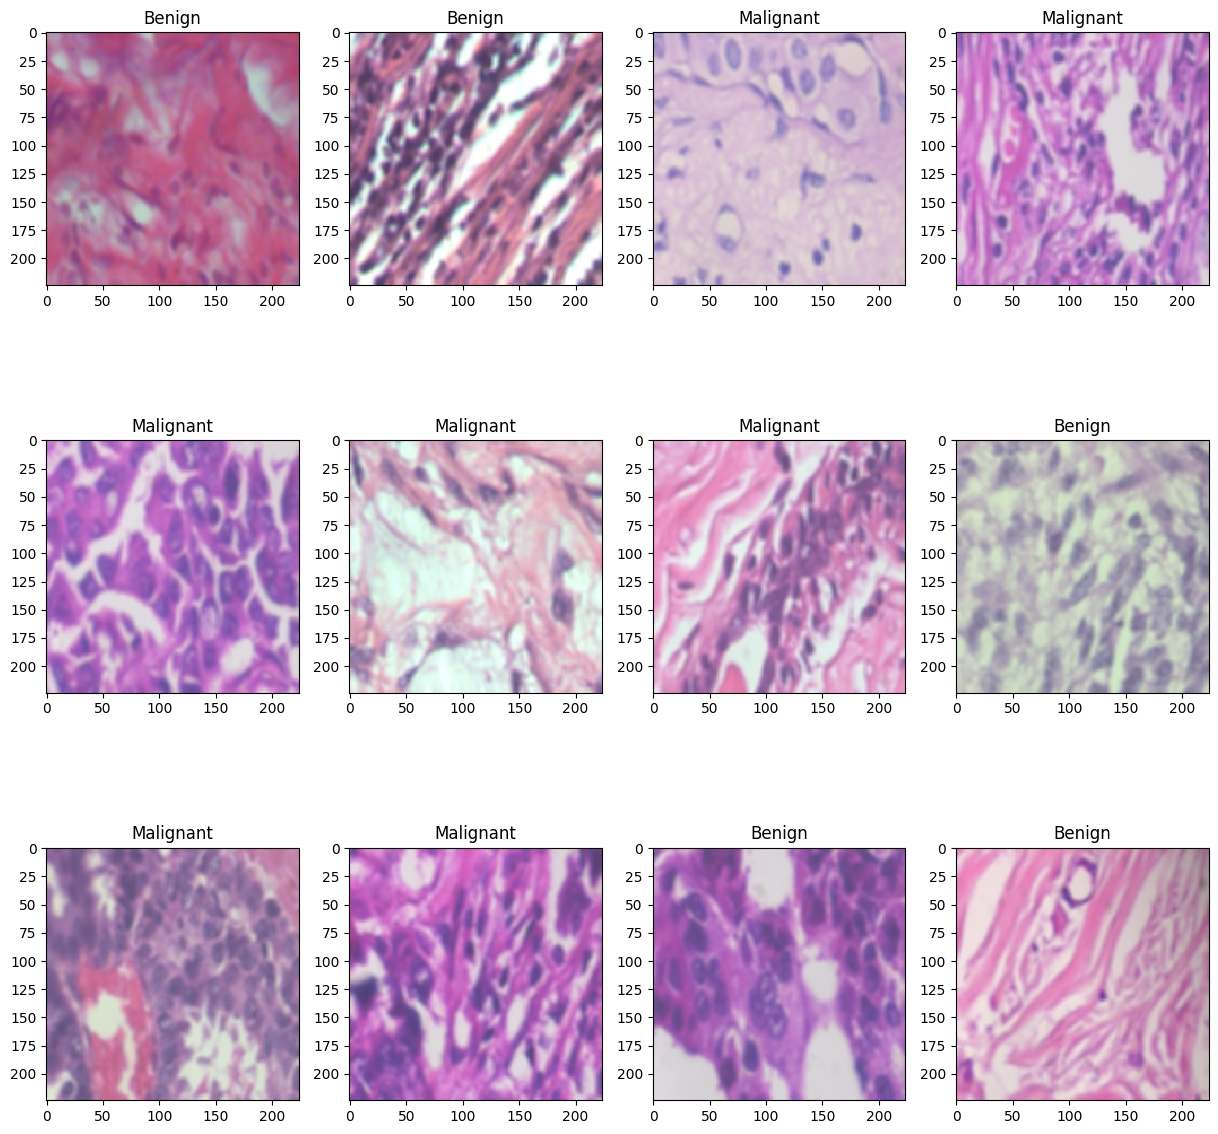

In [6]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
#plt.show()
BATCH_SIZE = 16
# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))


    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )

    return model
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)





model = build_model(resnet ,lr = 1e-4)
model.summary()

In [7]:
from keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.metrics import accuracy_score

filepath = "C:\\Users\\Varsha\\Desktop\\DataSources\\BreaKHis 400X"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint]
)
model.load_weights("C:\\Users\\Varsha\\Desktop\\DataSources\\BreaKHis 400X")

Y_val_pred = model.predict(x_val)
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

C:\Users\Varsha\AppData\Local\Temp\ipykernel_12444\4117714518.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20



58/57 [==============================] - ETA: -5s - loss: 0.5116 - accuracy: 0.7941
Epoch 1: val_accuracy improved from -inf to 0.26087, saving model to C:\Users\Varsha\Desktop\DataSources\BreaKHis 400X
INFO:tensorflow:Assets written to: C:\Users\Varsha\Desktop\DataSources\BreaKHis 400X\assets


INFO:tensorflow:Assets written to: C:\Users\Varsha\Desktop\DataSources\BreaKHis 400X\assets


57/57 [==============================] - 818s 13s/step - loss: 0.5116 - accuracy: 0.7941 - val_loss: 1633.4403 - val_accuracy: 0.2609
Epoch 2/20
58/57 [==============================] - ETA: -4s - loss: 0.4679 - accuracy: 0.8061
Epoch 2: val_accuracy improved from 0.26087 to 0.73913, saving model to C:\Users\Varsha\Desktop\DataSources\BreaKHis 400X
INFO:tensorflow:Assets written to: C:\Users\Varsha\Desktop\DataSources\BreaKHis 400X\assets


INFO:tensorflow:Assets written to: C:\Users\Varsha\Desktop\DataSources\BreaKHis 400X\assets


57/57 [==============================] - 817s 12s/step - loss: 0.4679 - accuracy: 0.8061 - val_loss: 4.7278 - val_accuracy: 0.7391
Epoch 3/20
58/57 [==============================] - ETA: -4s - loss: 0.4303 - accuracy: 0.8290
Epoch 3: val_accuracy improved from 0.73913 to 0.74348, saving model to C:\Users\Varsha\Desktop\DataSources\BreaKHis 400X
INFO:tensorflow:Assets written to: C:\Users\Varsha\Desktop\DataSources\BreaKHis 400X\assets


INFO:tensorflow:Assets written to: C:\Users\Varsha\Desktop\DataSources\BreaKHis 400X\assets


57/57 [==============================] - 830s 13s/step - loss: 0.4303 - accuracy: 0.8290 - val_loss: 0.7691 - val_accuracy: 0.7435
Epoch 4/20
58/57 [==============================] - ETA: -5s - loss: 0.4341 - accuracy: 0.8224
Epoch 4: val_accuracy improved from 0.74348 to 0.83478, saving model to C:\Users\Varsha\Desktop\DataSources\BreaKHis 400X
INFO:tensorflow:Assets written to: C:\Users\Varsha\Desktop\DataSources\BreaKHis 400X\assets


INFO:tensorflow:Assets written to: C:\Users\Varsha\Desktop\DataSources\BreaKHis 400X\assets


57/57 [==============================] - 875s 14s/step - loss: 0.4341 - accuracy: 0.8224 - val_loss: 2.6398 - val_accuracy: 0.8348
Epoch 5/20
58/57 [==============================] - ETA: -6s - loss: 0.4126 - accuracy: 0.8355
Epoch 5: val_accuracy did not improve from 0.83478
57/57 [==============================] - 757s 11s/step - loss: 0.4126 - accuracy: 0.8355 - val_loss: 1.0100 - val_accuracy: 0.7826
Epoch 6/20
58/57 [==============================] - ETA: -5s - loss: 0.3987 - accuracy: 0.8519
Epoch 6: val_accuracy did not improve from 0.83478
57/57 [==============================] - 619s 11s/step - loss: 0.3987 - accuracy: 0.8519 - val_loss: 1.1387 - val_accuracy: 0.3696
Epoch 7/20
58/57 [==============================] - ETA: -4s - loss: 0.3896 - accuracy: 0.8366
Epoch 7: val_accuracy improved from 0.83478 to 0.86087, saving model to C:\Users\Varsha\Desktop\DataSources\BreaKHis 400X
INFO:tensorflow:Assets written to: C:\Users\Varsha\Desktop\DataSources\BreaKHis 400X\assets


INFO:tensorflow:Assets written to: C:\Users\Varsha\Desktop\DataSources\BreaKHis 400X\assets


57/57 [==============================] - 779s 13s/step - loss: 0.3896 - accuracy: 0.8366 - val_loss: 0.5500 - val_accuracy: 0.8609
Epoch 8/20
58/57 [==============================] - ETA: -3s - loss: 0.3655 - accuracy: 0.8562
Epoch 8: val_accuracy did not improve from 0.86087
57/57 [==============================] - 497s 7s/step - loss: 0.3655 - accuracy: 0.8562 - val_loss: 0.4967 - val_accuracy: 0.7783
Epoch 9/20
58/57 [==============================] - ETA: -2s - loss: 0.3610 - accuracy: 0.8519
Epoch 9: val_accuracy did not improve from 0.86087
57/57 [==============================] - 328s 6s/step - loss: 0.3610 - accuracy: 0.8519 - val_loss: 1.2871 - val_accuracy: 0.8435
Epoch 10/20
58/57 [==============================] - ETA: -2s - loss: 0.3725 - accuracy: 0.8475
Epoch 10: val_accuracy did not improve from 0.86087
57/57 [==============================] - 327s 6s/step - loss: 0.3725 - accuracy: 0.8475 - val_loss: 0.4164 - val_accuracy: 0.8000
Epoch 11/20
58/57 [====================

INFO:tensorflow:Assets written to: C:\Users\Varsha\Desktop\DataSources\BreaKHis 400X\assets


57/57 [==============================] - 612s 11s/step - loss: 0.3220 - accuracy: 0.8682 - val_loss: 0.5965 - val_accuracy: 0.8870
Epoch 13/20
58/57 [==============================] - ETA: -4s - loss: 0.3414 - accuracy: 0.8399
Epoch 13: val_accuracy did not improve from 0.88696
57/57 [==============================] - 551s 8s/step - loss: 0.3414 - accuracy: 0.8399 - val_loss: 0.5888 - val_accuracy: 0.8478
Epoch 14/20
58/57 [==============================] - ETA: -3s - loss: 0.3209 - accuracy: 0.8725
Epoch 14: val_accuracy improved from 0.88696 to 0.90000, saving model to C:\Users\Varsha\Desktop\DataSources\BreaKHis 400X
INFO:tensorflow:Assets written to: C:\Users\Varsha\Desktop\DataSources\BreaKHis 400X\assets


INFO:tensorflow:Assets written to: C:\Users\Varsha\Desktop\DataSources\BreaKHis 400X\assets


57/57 [==============================] - 635s 11s/step - loss: 0.3209 - accuracy: 0.8725 - val_loss: 0.3529 - val_accuracy: 0.9000
Epoch 15/20
58/57 [==============================] - ETA: -4s - loss: 0.3339 - accuracy: 0.8606
Epoch 15: val_accuracy did not improve from 0.90000
57/57 [==============================] - 567s 8s/step - loss: 0.3339 - accuracy: 0.8606 - val_loss: 2.7104 - val_accuracy: 0.3652
Epoch 16/20
58/57 [==============================] - ETA: -3s - loss: 0.3467 - accuracy: 0.8508
Epoch 16: val_accuracy did not improve from 0.90000
57/57 [==============================] - 368s 6s/step - loss: 0.3467 - accuracy: 0.8508 - val_loss: 1.9322 - val_accuracy: 0.7087
Epoch 17/20
58/57 [==============================] - ETA: -3s - loss: 0.3165 - accuracy: 0.8736
Epoch 17: val_accuracy did not improve from 0.90000
57/57 [==============================] - 388s 7s/step - loss: 0.3165 - accuracy: 0.8736 - val_loss: 1.2948 - val_accuracy: 0.6087
Epoch 18/20
58/57 [================

8/8 [==============================] - 89s 4s/step


0.9

<Axes: >

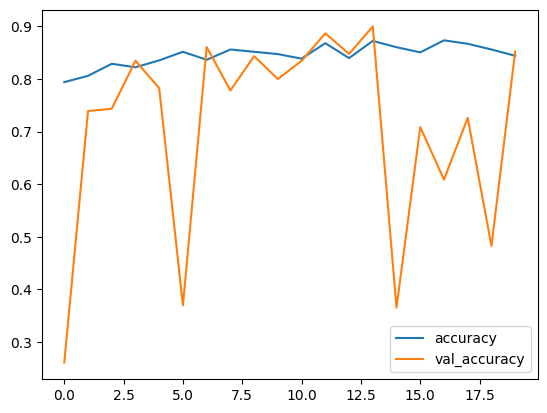

In [8]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

<Axes: >

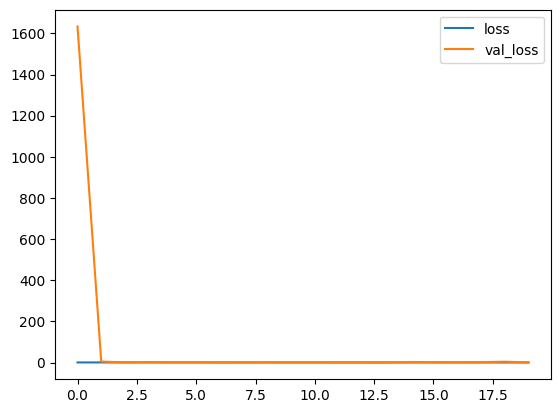

In [9]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [10]:
model.load_weights("C:\\Users\\Varsha\\Desktop\\DataSources\\BreaKHis 400X")

Y_val_pred = model.predict(x_val)
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

8/8 [==============================] - 20s 2s/step


0.9

18/18 [==============================] - 42s 2s/step


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\Varsha\AppData\Local\Temp\ipykernel_12444\1644120950.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [10:25<00:00, 62.55s/it]


Confusion matrix, without normalization
[[134  42]
 [ 29 340]]


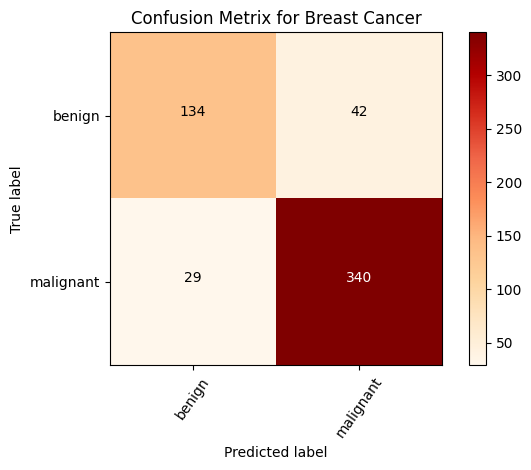

In [11]:
Y_pred = model.predict(X_test)
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)

    predictions.append(preds)
    gc.collect()

Y_pred_tta = np.mean(predictions, axis=0)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap='OrRd')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

Confusion matrix, without normalization
[[131  45]
 [ 25 344]]


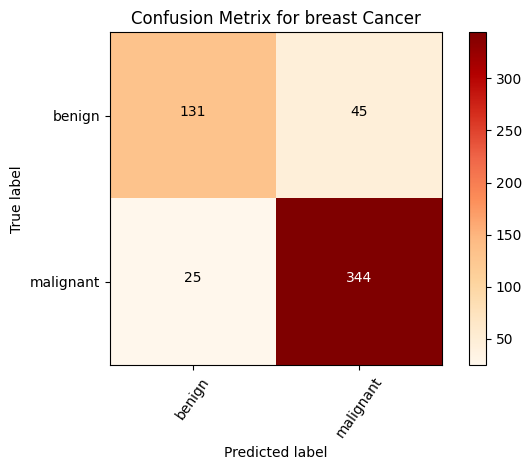

In [12]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for breast Cancer')

In [13]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.84      0.74      0.79       176\n           1       0.88      0.93      0.91       369\n\n    accuracy                           0.87       545\n   macro avg       0.86      0.84      0.85       545\nweighted avg       0.87      0.87      0.87       545\n'

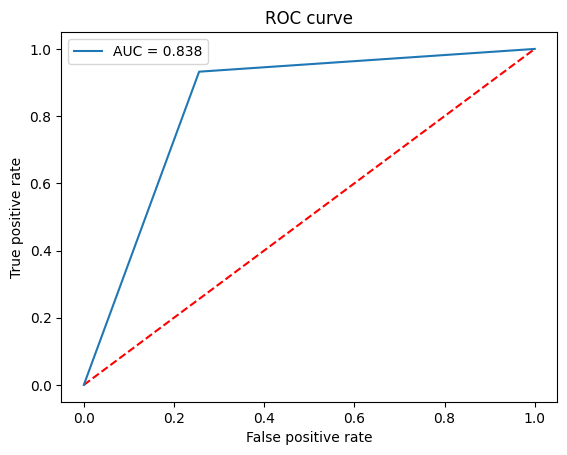

In [14]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC

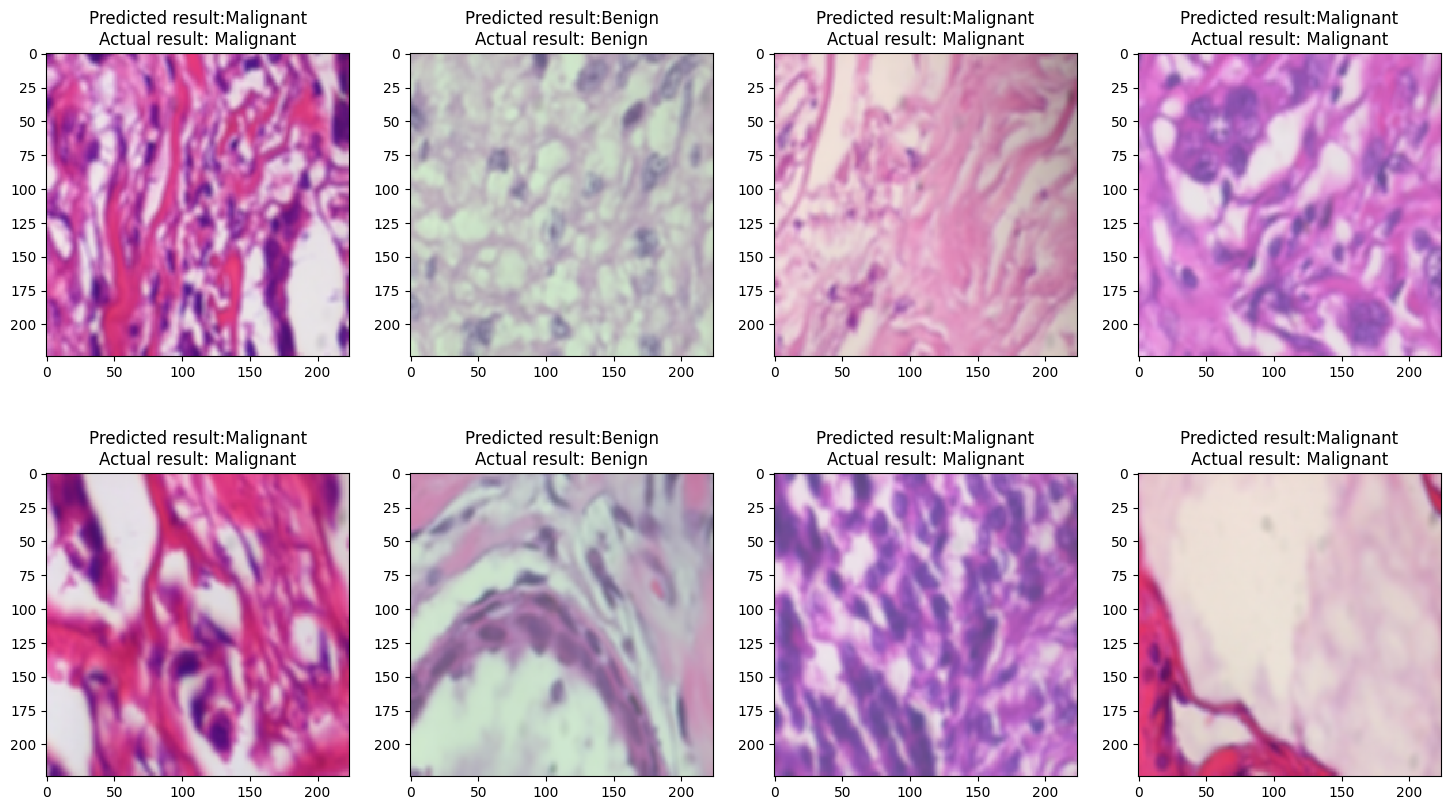

In [15]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 random images
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

In [18]:
model.save("trained.h5")

1/1 [==============================] - 3s 3s/step
Prediction: benign


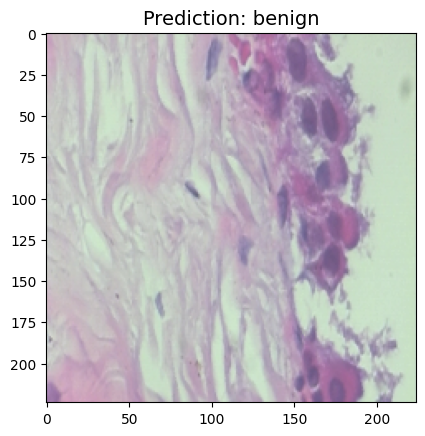

In [33]:
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Load the model
model = load_model("trained.h5")

# Load and preprocess the image
img_path = "C:\\Users\\Varsha\\Desktop\\DataSources\\BreaKHis 400X\\test\\benign\\SOB_B_A-14-22549AB-400-001.png"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img = np.expand_dims(img_array, axis=0)

# Make the prediction
try:
    prediction_prob = model.predict(img)
except ValueError as e:
    print("Error during prediction:", e)

# Convert prediction probability to a class label
predicted_class = np.argmax(prediction_prob, axis=1)

# Map the predicted class to a label (assuming class 0 is "Normal" and class 1 is "Malign")
class_labels = ["benign", "malignant"]
prediction_label = class_labels[predicted_class[0]]

# Display the prediction result
print("Prediction: " + prediction_label)

# Load and display the original image
tempimg = image.load_img(img_path, target_size=(224, 224))
plt.imshow(tempimg)
plt.title("Prediction: " + prediction_label, fontsize=14)
plt.show()


1/1 [==============================] - 3s 3s/step
Prediction: Malignant


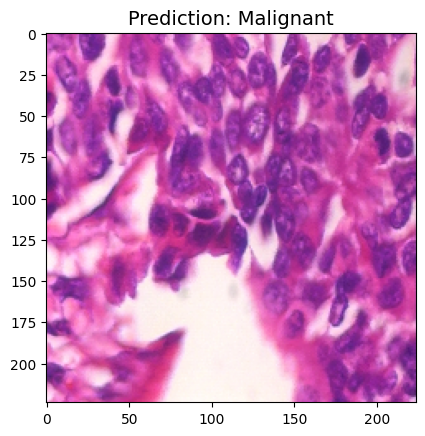

In [40]:
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Load the model
model = load_model("trained.h5")

img_path = "C:\\Users\\Varsha\\Desktop\\DataSources\\BreaKHis 400X\\train\\malignant\\SOB_M_DC-14-2523-400-004.png"
tempimg = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(tempimg)
img_array = preprocess_input(img_array)
img = np.expand_dims(img_array, axis=0)

# Make the prediction
prediction = model.predict(img)

# Check if the maximum predicted probability is greater than or equal to 0.5
if np.max(prediction) >= 0.5:
    prediction_label = "Malignant"
else:
    prediction_label = "Benign"

print("Prediction: " + prediction_label)

# Display the original image
plt.imshow(tempimg)
plt.title("Prediction: " + prediction_label, fontsize=14)
plt.show()


In [69]:
model.save("trained.h5")

In [70]:
model.save("trained")

INFO:tensorflow:Assets written to: trained\assets


INFO:tensorflow:Assets written to: trained\assets
